<a href="https://colab.research.google.com/github/Ujjwal10228/Stock-Price-Forecasting/blob/main/FTSE_100_Stock_Prediction_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
import pandas as pd
from datetime import datetime  # Import the datetime module

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')  # Use datetime.strptime
df = pd.read_excel('/content/Forecasting FTSE100 Index - Dataset - v1.1.xlsx', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-09-01,5394.5,5449.7,5346.7,5418.7,5418.7,975363800
2011-09-02,5418.7,5418.7,5258.5,5292.0,5292.0,823930000
2011-09-05,5292.0,5292.0,5097.7,5102.6,5102.6,788821300
2011-09-06,5102.6,5190.3,5086.8,5156.8,5156.8,946079100
2011-09-07,5156.8,5322.2,5156.8,5318.6,5318.6,837910500


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-06,7437.9,7447.9,7369.6,7426.1,7426.1,448751100
2023-09-07,7426.1,7462.2,7385.9,7441.7,7441.7,456225400
2023-09-08,7441.7,7480.6,7402.1,7478.2,7478.2,651366100
2023-09-11,7478.2,7549.3,7467.4,7496.9,7496.9,568717300
2023-09-12,7478.2,7549.3,7467.4,7496.9,7496.9,568717300


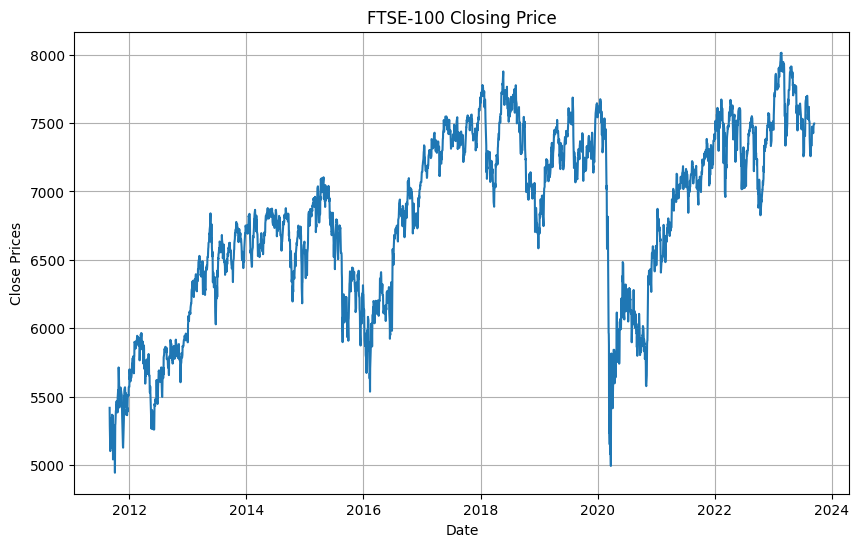

In [ ]:
#Plot Close Price

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('FTSE-100 Closing Price')
plt.show()

In [ ]:
df.size #Size of Close Index

18834

<Axes: ylabel='Density'>

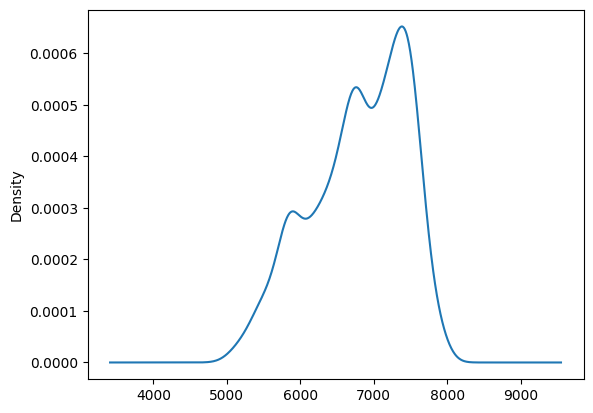

In [ ]:
# Probability Distribution Visualization - Distribution of Dataset
df_close = df['Close']
df_close.plot(kind='kde')


###A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.

**The following are the components’ definitions:**

* The average value in the series is called the level.
* The increasing or falling value in the series is referred to as the trend.
* Seasonality is the series’ recurring short-term cycle.
* The random variance in the series is referred to as noise.

Time series analysis only works with stationary data, we must first determine whether a series is stationary.

In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03
mean,6793.606371,6833.296305,6753.535680,6794.431857,6794.431857,7.813391e+08
std,649.958685,644.608521,655.918874,649.676189,649.676189,2.657267e+08
min,4944.400000,5075.500000,4868.600000,4944.400000,4944.400000,8.378200e+06
25%,6338.800000,6380.500000,6297.450000,6339.050000,6339.050000,6.323042e+08
50%,6855.100000,6884.600000,6819.300000,6855.800000,6855.800000,7.458386e+08
75%,7337.900000,7377.400000,7302.700000,7337.900000,7337.900000,8.748451e+08
max,8014.300000,8047.100000,7995.500000,8014.300000,8014.300000,3.761301e+09


**ADF (Augmented Dickey-Fuller) Test**

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

**Null Hypothesis**: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

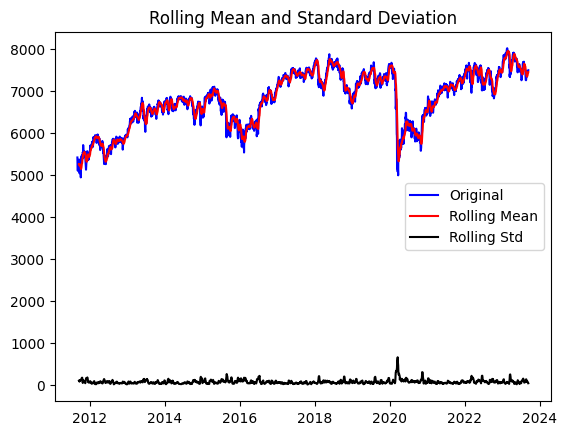

Results of Dickey Fuller Test
Test Statistics               -3.148772
p-value                        0.023148
No.of lags used                9.000000
No. of observations used    3129.000000
critical value (1%)           -3.432442
critical value (5%)           -2.862464
critical value (10%)          -2.567262
dtype: float64


In [ ]:
## Test for Stationary

def test_stationarity(timeseries):

  #Determine rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()

  # Plot rolling statistics:
  plt.plot(timeseries, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title("Rolling Mean and Standard Deviation")
  plt.show(block=False)
  print("Results of Dickey Fuller Test")
  adft=adfuller(timeseries,autolag='AIC')

  # Output for dft will give us without defining what the values are.
  # hence we manually write what values does it explains using a for loop
  output= pd.Series(adft[0:4], index=['Test Statistics','p-value', 'No.of lags used', 'No. of observations used'])
  for key, values in adft[4].items():
    output['critical value (%s)'%key]= values
  print(output)
test_stationarity(df_close)


In [ ]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Close'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(df['Close'])

ADF Test Statistic : -3.148771835474012
p-value : 0.023148147323080202
#Lags Used : 9
Number of Observations Used : 3129
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### From the result of the Stationary Tests we can say that our data is Stationary so now we can apply the ARIMA Model

In [ ]:
# Split data into train and test set
# Test data is 15 days
train_data, test_data = df_close[3:int(len(df_close)*0.995)], df_close[int(len(df_close)*0.995):]

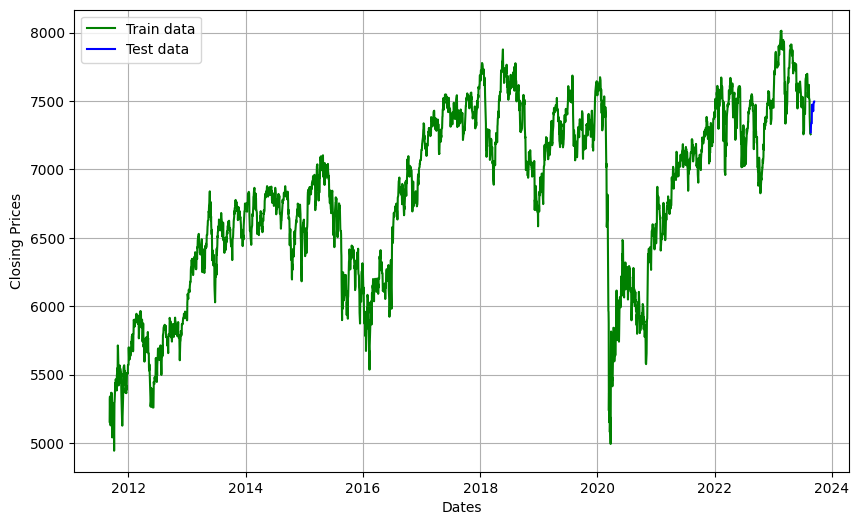

In [ ]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

**Auto ARIMA: Automatically discover the optimal order for an ARIMA model.**

The auto_arima function returns a fitted ARIMA model after determining the most optimal parameters for an ARIMA model. This function is based on the forecast::auto. Arima R function, which is widely used

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=63943.755, Time=0.84 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=3.53 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.72 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=34744.391, Time=3.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=34737.281, Time=5.93 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=4.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=34737.868, Time=5.74 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=34737.885, Time=7.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=34745.759, Time=4.97 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=4.96 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=34733.218, Time=5.64 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=34738.623, Time=3.63 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=34740.040, Time=4.07 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=34736.858, Time=9.06 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]       

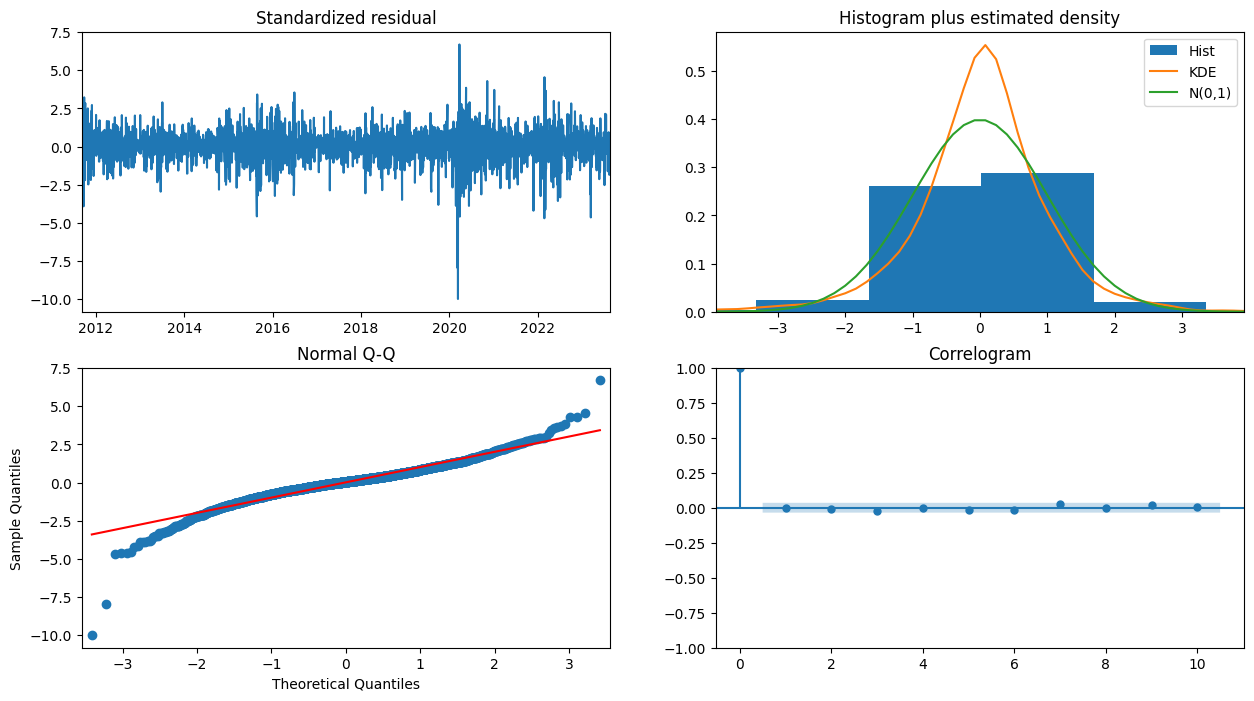

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=3, max_q=3, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

### **The plot diagnostics be interpreted as:**

**Top left:** The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

**Top Right:** The density plot on the top right suggests a normal distribution with a mean of zero.

**Bottom left:** The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

**Bottom Right:** The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, we’ll need to add more Xs (predictors) to the model.

As a result, the Auto ARIMA model assigned the values 3, 1, and 3 to, p, d, and q, respectively.

In [ ]:
# Modelling
# Build Model

from statsmodels.tsa.arima.model import ARIMA
# model = ARIMA(train_data, order=(0, 1, 2))
model = ARIMA(train_data, order=(3, 1, 3))

fitted = model.fit()
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3120
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -17347.643
Date:                Sun, 07 Jul 2024   AIC                          34709.285
Time:                        12:08:17   BIC                          34751.602
Sample:                    09-06-2011   HQIC                         34724.476
                         - 08-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7763      0.079     -9.872      0.000      -0.930      -0.622
ar.L2          0.8913      0.020     44.285      0.000       0.852       0.931
ar.L3          0.8240      0.070     11.736      0.0

Let’s now begin forecasting stock prices on the test dataset with a 95% confidence level.

In [ ]:
# Forecast
# forecast_result= fitted.forecast(321, alpha=0.05) #95% conf
# fc, se, conf = forecast_result[0], forecast_result[1], forecast_result[2]

# forecast_result= fitted.forecast(len(test_data), alpha=0.07) #95% conf
forecast_result= fitted.forecast(len(test_data), alpha=0.05)
fc, se, conf = forecast_result[0], forecast_result[1], forecast_result[2]

In [ ]:
# Make as pandas Series
fc_series=pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf, index=test_data.index)
upper_series = pd.Series(conf, index=test_data.index)

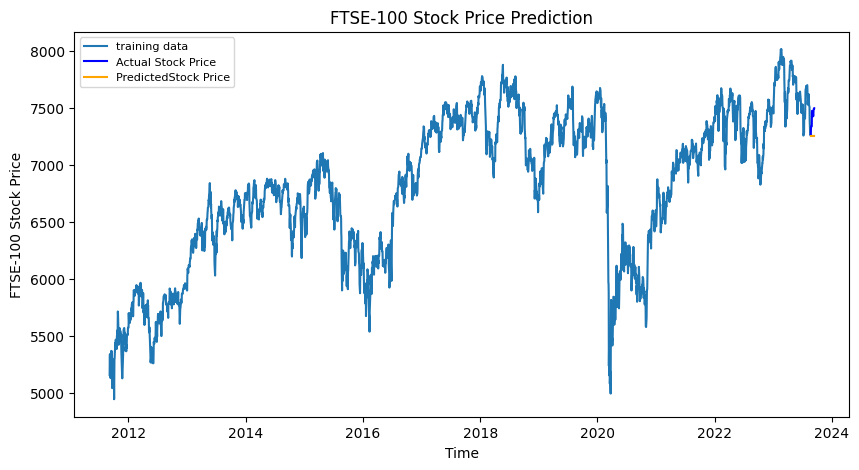

In [ ]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='PredictedStock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('FTSE-100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FTSE-100 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Forecast for the same number of steps as in test_data
forecast_result= fitted.forecast(len(test_data), alpha=0.05) #95% conf
fc, se, conf = forecast_result[0], forecast_result[1], forecast_result[2]
# fc, se, conf = fitted.forecast(len(test_data), alpha=0.05)

# Make sure fc has the same length and index as test_data
fc_series = pd.Series(fc, index=test_data.index)

# report performance
mse = mean_squared_error(test_data, fc_series)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_data, fc_series)
print('MAE: ' + str(mae))

rmse = np.sqrt(mean_squared_error(test_data, fc_series))
print('RMSE: ' + str(rmse))

mape = np.mean(np.abs(fc_series - test_data) / np.abs(test_data))
print('MAPE: ' + str(mape))


MSE: 30723.942742214742
MAE: 160.9463962590566
RMSE: 175.28246558687707
MAPE: 0.021612819299980268


With a MAPE of around 2.1%, the model is 97.9% accurate in predicting the next 15 observations.

In [ ]:
100-2.1

97.9